### 1 - Importons les différentes librairies 

In [34]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
#import pytz
import pygeohash as gh
#from haversine import haversine
import time
#from zodbpickle import pickle
import glob
#import json
import warnings
import re
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
import streamlit as st
geohash_prec = 5 # the geo-hash level to define a region R

### 2 - Créons la description des vecteurs features pour GeoHashes

In [2]:
cities = {'LosAngeles': [33.700615, 34.353627, -118.683511, -118.074559], 
           'Houston': [29.497907,30.129003,-95.797178,-94.988191],
           'Austin': [30.079327, 30.596764,-97.968881,-97.504838],
           'Dallas': [32.559567,33.083278,-97.036586,-96.428928],
           'Charlotte': [34.970168,35.423667,-81.060925,-80.622687],
           'Atlanta': [33.612410,33.916999,-84.575600,-84.231911]}

time_zones = {'Houston':'US/Central', 'Charlotte':'US/Eastern', 'Dallas':'US/Central',
              'Atlanta':'US/Eastern', 'Austin':'US/Central', 'LosAngeles':'US/Pacific'}

# time interval to sample data for 
start = datetime(2018, 6, 1)
finish   = datetime(2018, 9, 2)

begin = datetime.strptime('2018-06-01 00:00:00', '%Y-%m-%d %H:%M:%S')
end   = datetime.strptime('2018-08-31 23:59:59', '%Y-%m-%d %H:%M:%S')

#### 3- Data Viz

In [3]:
Atlanta = pd.read_csv("data/temporary/TW_EVENT_Atlanta_20180601_20180609.csv")
Atlanta = Atlanta[Atlanta["City"] == "Atlanta"]
Charlotte = pd.read_csv("data/temporary/TW_EVENT_Charlotte_20180601_20180609.csv")
Charlotte = Charlotte[Charlotte["City"] == "Charlotte"]
Dallas = pd.read_csv("data/temporary/TW_EVENT_Dallas_20180601_20180609.csv")
Dallas = Dallas[Dallas["City"] == "Dallas"]
Austin = pd.read_csv("data/temporary/TW_EVENT_Austin_20180601_20180609.csv")
Austin = Austin[Austin["City"] == "Austin"]
Houston = pd.read_csv("data/temporary/TW_EVENT_Houston_20180601_20180609.csv")
Houston = Houston[Houston["City"] == "Houston"]
Losangeles = pd.read_csv("data/temporary/TW_EVENT_Losangeles_20180601_20180609.csv")
Losangeles = Losangeles[Losangeles["City"] == "Los Angeles"]

In [4]:
trafic_data = pd.concat([Atlanta, Charlotte, Dallas, Austin, Houston, Losangeles])

In [5]:
trafic_data.to_csv('data/traffic_data/traffic_data_20180601_20180609.csv', index=False)

In [8]:
data_accident = trafic_data[trafic_data["Type"] == "Accident"]

In [9]:
data_accident.tail()

,EventId,Source,Type,Severity,TMC,Description,StartTime(UTC),EndTime(UTC),TimeZone,LocationLat,LocationLng,Distance(mi),AirportCode,Number,Street,Side,City,County,State,ZipCode
90911,T-14406251,T,Accident,NaN,201.0,Accident on Firestone Blvd at Compton Ave.,2018-06-30 02:22:36,2018-06-30 03:07:22,US/Pacific,33.960155,-118.247437,0.0,KCQT,1499.0,Firestone Blvd,L,Los Angeles,Los Angeles,CA,90001.0
90912,T-14406252,T,Accident,NaN,203.0,2 right lane blocked due to multi-vehicle acci...,2018-06-30 02:21:38,2018-06-30 03:06:01,US/Pacific,34.030785,-118.436348,0.0,KSMO,NaN,I-10 E,R,Los Angeles,Los Angeles,CA,90064.0
90916,T-14406266,T,Accident,NaN,201.0,Middle lane blocked due to accident on I-405 S...,2018-06-30 02:26:40,2018-06-30 03:11:10,US/Pacific,34.055695,-118.451965,0.0,KSMO,NaN,I-405 N,R,Los Angeles,Los Angeles,CA,90025.0
90939,T-14406316,T,Accident,NaN,201.0,Middle lane blocked due to accident on I-110 N...,2018-06-30 03:34:41,2018-06-30 04:18:51,US/Pacific,34.003773,-118.281029,0.0,KCQT,NaN,Harbor Fwy N,R,Los Angeles,Los Angeles,CA,90037.0
90954,T-14406338,T,Accident,NaN,201.0,Accident on CA-110 Southbound at Stadium Way.,2018-06-30 04:24:10,2018-06-30 05:08:45,US/Pacific,34.071346,-118.235413,0.0,KCQT,NaN,Pasadena Fwy S,R,Los Angeles,Los Angeles,CA,90012.0


In [10]:
data_accident["StartTime(UTC)"] = data_accident["StartTime(UTC)"].map(pd.to_datetime)

In [11]:
def get_dom(dt):
    return dt.day
def get_weekday(dt):
    return dt.weekday()
def get_hour(dt):
    return dt.hour

In [22]:
data_accident["dom"] = data_accident["StartTime(UTC)"].map(get_dom)
data_accident["weekday"] = data_accident["StartTime(UTC)"].map(get_weekday)
data_accident["hour"] = data_accident["StartTime(UTC)"].map(get_hour)

In [23]:
data_accident.to_csv('data/traffic_accident_data/traffic_accident_data_20180601_20180609.csv', index=False)

In [24]:
df = pd.read_csv('data/traffic_accident_data/traffic_accident_data_20180601_20180609.csv')

In [25]:
df.tail()

,EventId,Source,Type,Severity,TMC,Description,StartTime(UTC),EndTime(UTC),TimeZone,LocationLat,...,Number,Street,Side,City,County,State,ZipCode,dom,weekday,hour
23015,T-14406251,T,Accident,NaN,201.0,Accident on Firestone Blvd at Compton Ave.,2018-06-30 02:22:36,2018-06-30 03:07:22,US/Pacific,33.960155,...,1499.0,Firestone Blvd,L,Los Angeles,Los Angeles,CA,90001.0,30,5,2
23016,T-14406252,T,Accident,NaN,203.0,2 right lane blocked due to multi-vehicle acci...,2018-06-30 02:21:38,2018-06-30 03:06:01,US/Pacific,34.030785,...,NaN,I-10 E,R,Los Angeles,Los Angeles,CA,90064.0,30,5,2
23017,T-14406266,T,Accident,NaN,201.0,Middle lane blocked due to accident on I-405 S...,2018-06-30 02:26:40,2018-06-30 03:11:10,US/Pacific,34.055695,...,NaN,I-405 N,R,Los Angeles,Los Angeles,CA,90025.0,30,5,2
23018,T-14406316,T,Accident,NaN,201.0,Middle lane blocked due to accident on I-110 N...,2018-06-30 03:34:41,2018-06-30 04:18:51,US/Pacific,34.003773,...,NaN,Harbor Fwy N,R,Los Angeles,Los Angeles,CA,90037.0,30,5,3
23019,T-14406338,T,Accident,NaN,201.0,Accident on CA-110 Southbound at Stadium Way.,2018-06-30 04:24:10,2018-06-30 05:08:45,US/Pacific,34.071346,...,NaN,Pasadena Fwy S,R,Los Angeles,Los Angeles,CA,90012.0,30,5,4


#### 3-1 Regardons la frequence d'accidents en fonction des jours du mois

Text(0.5, 1.0, 'Fequency by DoM -- Accident Trafic')

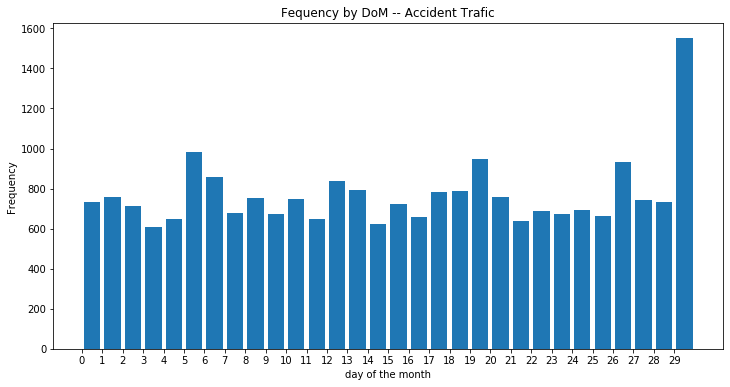

In [26]:
plt.figure(figsize=(12,6))
plt.hist(df.dom, bins =30, range = (1, 31), rwidth = 0.8)
plt.xticks(range(1,31), df.dom.index)
plt.xlabel("day of the month")
plt.ylabel("Frequency")
plt.title("Fequency by DoM -- Accident Trafic")

### 3-2 Regardons la frequence d'accidents en fonction des heures 

Text(0.5, 1.0, 'Fequency by Hour -- Accident Trafic')

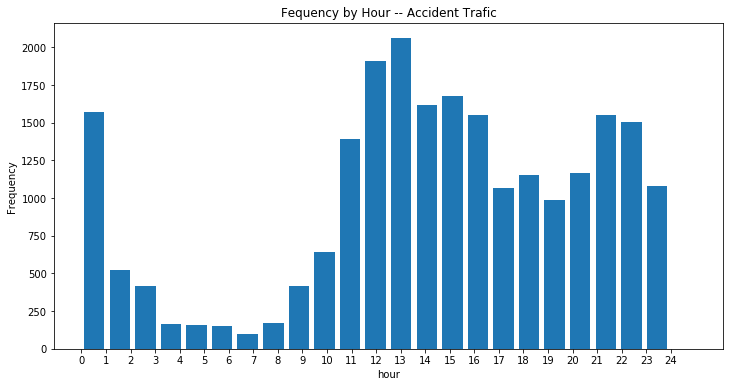

In [27]:
plt.figure(figsize=(12,6))
plt.hist(df.hour, bins = 24, range = (0, 25), rwidth = 0.8)
plt.xticks(range(0,25), df.hour.index)
plt.xlabel("hour")
plt.ylabel("Frequency")
plt.title("Fequency by Hour -- Accident Trafic")

### 3-3 Regardons la frequence d'accidents par jour de la semaine 

Text(0.5, 1.0, 'Fequency by weekday -- Accident Trafic')

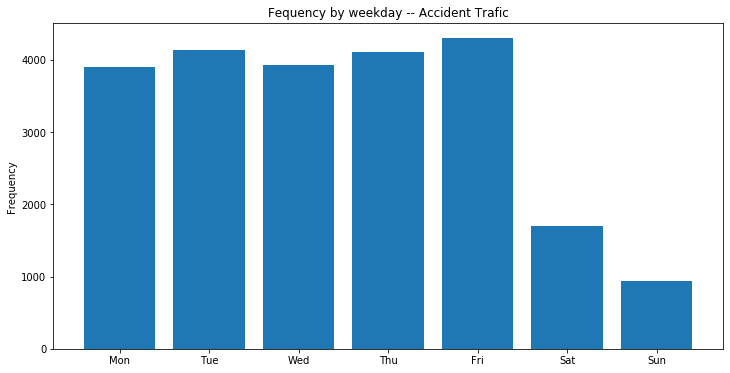

In [28]:
plt.figure(figsize=(12,6))
plt.hist(df.weekday, bins = 7, range = (-0.5, 6.5), rwidth = 0.8)
plt.xticks(range(7), "Mon Tue Wed Thu Fri Sat Sun".split())
plt.ylabel("Frequency")
plt.title("Fequency by weekday -- Accident Trafic")

In [29]:
by_weekday_hour = df.groupby("weekday hour".split()).apply(lambda x :len(x))

In [30]:
corr_weekday_hour = by_weekday_hour.unstack()
corr_weekday_hour

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
weekday,,,,,,,,,,,,,,,,,,,,,
0,29,55,47,11,29,26,26,10,30,89,...,280,323,265,181,198,168,206,312,288,188
1,165,114,73,73,12,14,16,13,21,55,...,288,302,265,177,218,169,215,302,283,190
2,162,112,87,74,24,19,27,11,26,64,...,277,283,279,172,166,147,182,257,260,207
3,171,111,73,69,18,25,28,18,29,81,...,310,277,291,197,191,161,184,253,284,194
4,169,98,94,88,29,26,19,12,34,95,...,326,339,294,171,170,203,227,298,274,181
5,157,133,85,89,32,19,15,15,14,21,...,89,106,113,119,124,82,95,74,69,70
6,37,57,63,12,20,27,18,19,17,14,...,49,45,44,50,83,56,57,54,45,51


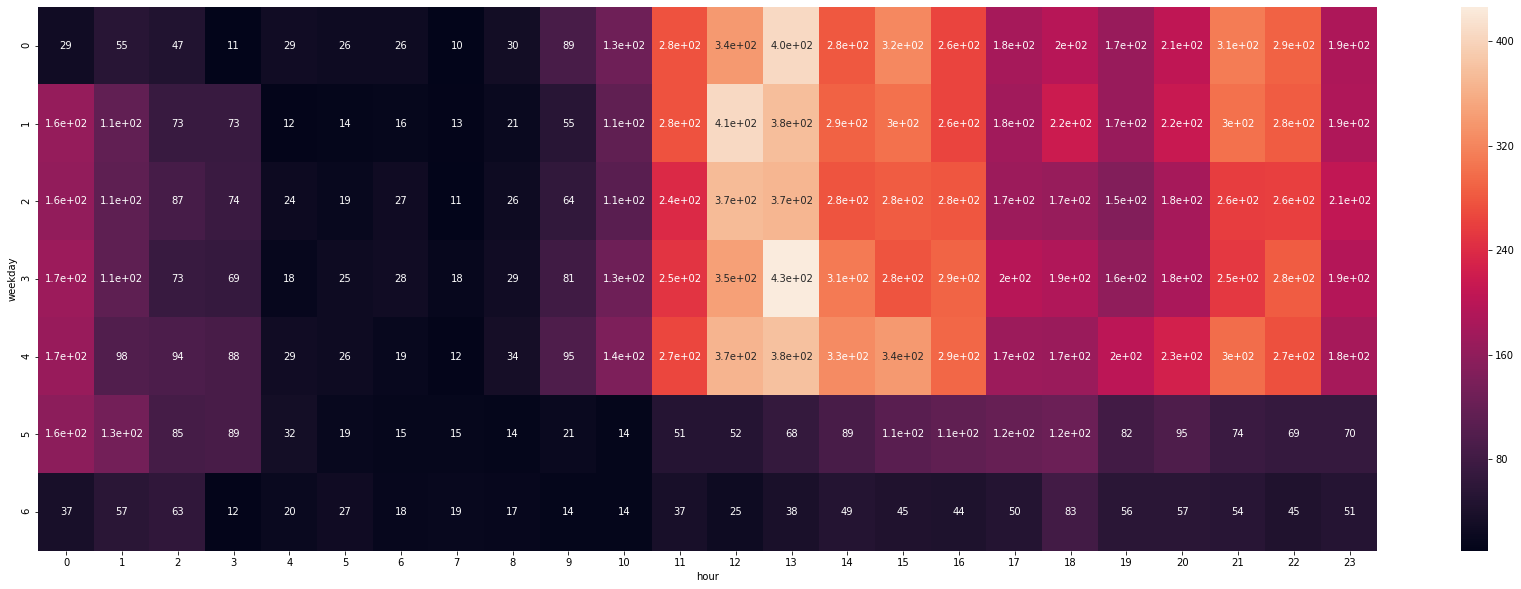

In [31]:
plt.subplots(figsize=(30, 10));
sns.heatmap(corr_weekday_hour, annot=True)

In [32]:
Atlanta = df[df["City"] == "Atlanta"]
Charlotte = df[df["City"] == "Charlotte"]
Dallas = df[df["City"] == "Dallas"]
Austin = df[df["City"] == "Austin"]
Houston = df[df["City"] == "Houston"]
Losangeles = df[df["City"] == "Los Angeles"]

### 3-4 Map pour Atlanta

In [36]:
cart_geo_coord = []
for i in range(len(Atlanta)):
    LatLon = [(Atlanta.LocationLat.iloc[i], Atlanta.LocationLng.iloc[i])]
    cart_geo_coord.extend( LatLon if LatLon else ['NULL']) 

In [38]:
import folium
latlon = cart_geo_coord
mapit = folium.Map( location=[33.75, -84.40], zoom_start=6 )
for coord in latlon:
    folium.Marker( location=[ coord[0], coord[1] ]).add_to( mapit )
mapit

### 3- Chargeons les vecteurs de GloVe Word Embedding 

In [6]:
word2vec = {}
with open('data/glove.6B/glove.6B.300d.txt', 'r') as reader: # suppose that we already downloaded this GloVe model. 
    # you can download this file from https://nlp.stanford.edu/projects/glove/
    for line in reader:
        parts = line.replace('\r', '').replace('\n', '').split(' ')
        v = [float(parts[i]) for i in range(1, len(parts))]
        word2vec[parts[0]] = v
        

print('loaded {} word vectors!'.format(len(word2vec)))

loaded 400000 word vectors!


In [7]:
def return_desc2vec(input):
    parts = re.split(' - | |\.|\\\|/|;|,|&|!|\?|\(|\)|\[|\]|\{|\}', input)
    parts = [p.lower() for p in parts]
    v = []
    for p in parts:
        if len(p) ==0: 
            continue
        if p in word2vec: 
            v.append(word2vec[p])
        #else: 
        #    v.append(word2vec['UNK'])
    if len(v) ==0: 
        print (input)
    v = np.mean(v, axis=0)
    return v

### 4- Utilisons le dataset du trafic pour créer le vecteur Embedding

In [21]:
# load valid geohashes
valid_geohashes = set() # we only generate data for those regions/geohashes that have valid POI data 
with open('data/geohash_to_poi_vec.csv', 'r') as reader:
    for line in reader:
        if 'Geohash' in line: 
            continue
        valid_geohashes.add(line.split(',')[0])

In [45]:
geo_to_vec = {}
start_timestamp = time.time()

for c in cities:
    
    # add map-quest data
    with open('data/temporary/TW_EVENT_{}_20180601_20180609.csv'.format(c), 'r') as file:
        header = False
        vect = []
        for line in file:
            if not header:
                header = True
                continue
            parts = line.replace('\r', '').replace('\n', '').split(',')
                        
            start_gh = gh.encode(float(parts[9]), float(parts[10]), precision=geohash_prec)     
            if start_gh not in valid_geohashes: 
                continue
            
            mat = ""
            if start_gh in valid_geohashes: 
                ve.append(start_gh)
            mat.append(return_desc2vec(parts[5]))
            geo_to_vec[start_gh] = mat
            

    
    print('Done with {} in {:.1f} sec!'.format(c,time.time()-start_timestamp))
    start_timestamp = time.time()
            


Done with LosAngeles in 21.4 sec!
Done with Houston in 11.4 sec!
Done with Austin in 4.7 sec!
Done with Dallas in 8.0 sec!
Done with Charlotte in 4.2 sec!
Done with Atlanta in 6.4 sec!


In [42]:
geo_to_vec = {}
start_timestamp = time.time()

for c in cities:
    
    # add map-quest data
    with open('data/temporary/TW_EVENT_{}_20180601_20180609.csv'.format(c), 'r') as file:
        header = False
        vect =[]
        for line in file:
            if not header:
                header = True
                continue
            parts = line.replace('\r', '').replace('\n', '').split(',')
                        
            start_gh = gh.encode(float(parts[9]), float(parts[10]), precision=geohash_prec)     
            mat = []
            if start_gh in valid_geohashes:
                mat.append(start_gh)
            vect.append(mat)
           

### 5- Créons et vidons un vecteur de caractéristique textuelle pour chaque Geohash

In [13]:
for c in cities :
  writer = open('data/description2vec/{}_geohash_to_text_vec.csv'.format(c), 'w')
  writer.write('Geohash,vec\n')

  for g in geo_to_vec:
      vec = list(np.mean(geo_to_vec[g], axis=0))
      v = [str(vec[i]) for i in range(len(vec))]
      v = ' '.join(v)
      writer.write(g + ',' + v + '\n')
  writer.close()

### !!! Fin du NL, pour la suite voir le fichier CleaningData !!!

In [4]:
Atlanta = pd.read_csv("data/description_to_vectors/Atlanta_geohash_to_text_vec.csv")

In [5]:
Atlanta

,Geohash,vec
0,9qh00,-0.07889174491871065 -0.12197949617484974 0.34...
1,9q5bn,-0.10269182958068042 -0.05096176422853554 0.40...
2,9q5bw,-0.03869675688981693 -0.13677212222463814 0.31...
3,9q5c1,0.036318202253480716 -0.06912836163523434 0.42...
4,9q5c5,0.015834442926542243 -0.1104896394737117 0.337...
5,9q5cb,0.036459017597155564 -0.20726607336429748 0.26...
6,9q5dq,0.03140533650243833 -0.19408564380573093 0.417...
7,9q5f2,0.020688076167998504 -0.18768813328781198 0.32...
8,9q5c4,0.03616485245534195 -0.13569325204585841 0.307...
9,9q5bm,0.0017513024693262427 -0.1807995401351595 0.26...
